# Project 2-  Customer Churn Prediction
## 1. Problem Definition
### We'll predict whether a customer will leave a service based on their usage pattern and demographic

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from lazypredict.Supervised import LazyClassifier

np.random.seed(42)

#Load the Telco custome chiun dataset (downloading from a common source)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
data = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset Shape: {data.shape}")
print(f"First five rows: {data.head()}")
display(data)


Dataset Shape: (7043, 21)
First five rows:    customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [93]:
data.info()
#missing values
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [94]:
# Check unique values in the target column
print("\nChurn Distribution:")
print(data['Churn'].value_counts())
print(data['Churn'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))



Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.46%
Yes    26.54%
Name: proportion, dtype: object


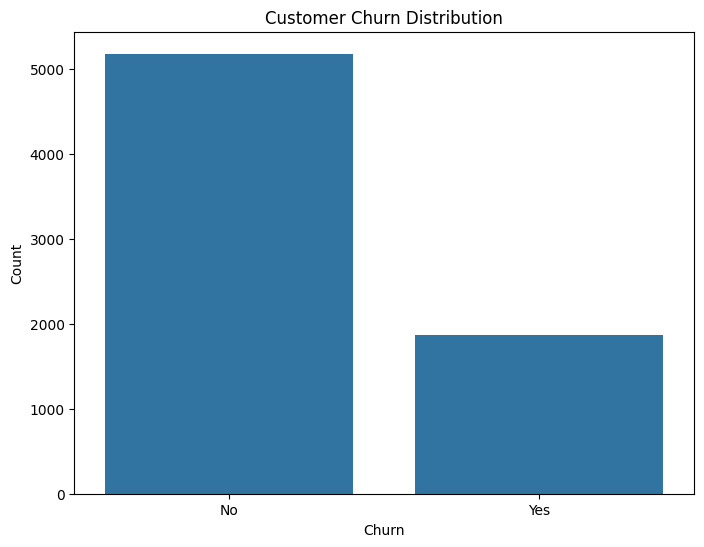

In [95]:
plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=data)
plt.title('Customer Churn Distribution')
plt.ylabel('Count')
plt.show()

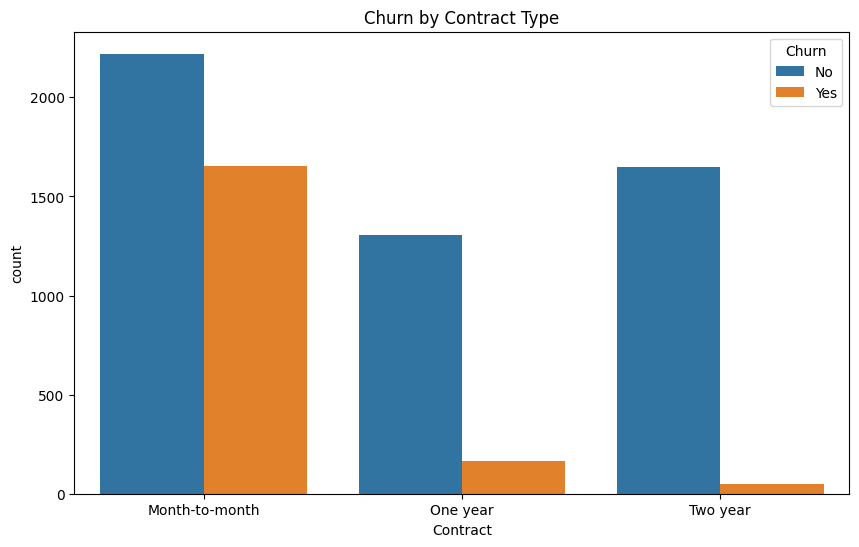

In [96]:
#Examine some key features related to Churn
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(10,6))
sns.countplot(x='Contract', hue='Churn', data=data)
plt.title('Churn by Contract Type')
plt.show()

In [97]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
#Convert TotalCharges to numeric (it might be loaded as object)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].isna().sum()
#check rows with missing Totalcharges
print("Rows with missing TotalCharges:")
print(data[data['TotalCharges'].isna()])

Rows with missing TotalCharges:
      customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
488   4472-LVYGI  Female              0  ...          52.55          NaN     No
753   3115-CZMZD    Male              0  ...          20.25          NaN     No
936   5709-LVOEQ  Female              0  ...          80.85          NaN     No
1082  4367-NUYAO    Male              0  ...          25.75          NaN     No
1340  1371-DWPAZ  Female              0  ...          56.05          NaN     No
3331  7644-OMVMY    Male              0  ...          19.85          NaN     No
3826  3213-VVOLG    Male              0  ...          25.35          NaN     No
4380  2520-SGTTA  Female              0  ...          20.00          NaN     No
5218  2923-ARZLG    Male              0  ...          19.70          NaN     No
6670  4075-WKNIU  Female              0  ...          73.35          NaN     No
6754  2775-SEFEE    Male              0  ...          61.90          NaN     No

[11 row

In [98]:
#Look at the relationship with Tenure
print("\nTenure for rows with missing TotalCharges:")
print(data[data['TotalCharges'].isna()]['tenure'])
# Because tenure for all the rows are ZERO, it could be because the customers are new
#Set TotalCharges equal to MonthlyCharges for these new customer
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = data.loc[data['TotalCharges'].isna(), 'MonthlyCharges']

# Confirm no more missing values
print("\nMissing values after imputation:")
print(data.isnull().sum())


Tenure for rows with missing TotalCharges:
488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

Missing values after imputation:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


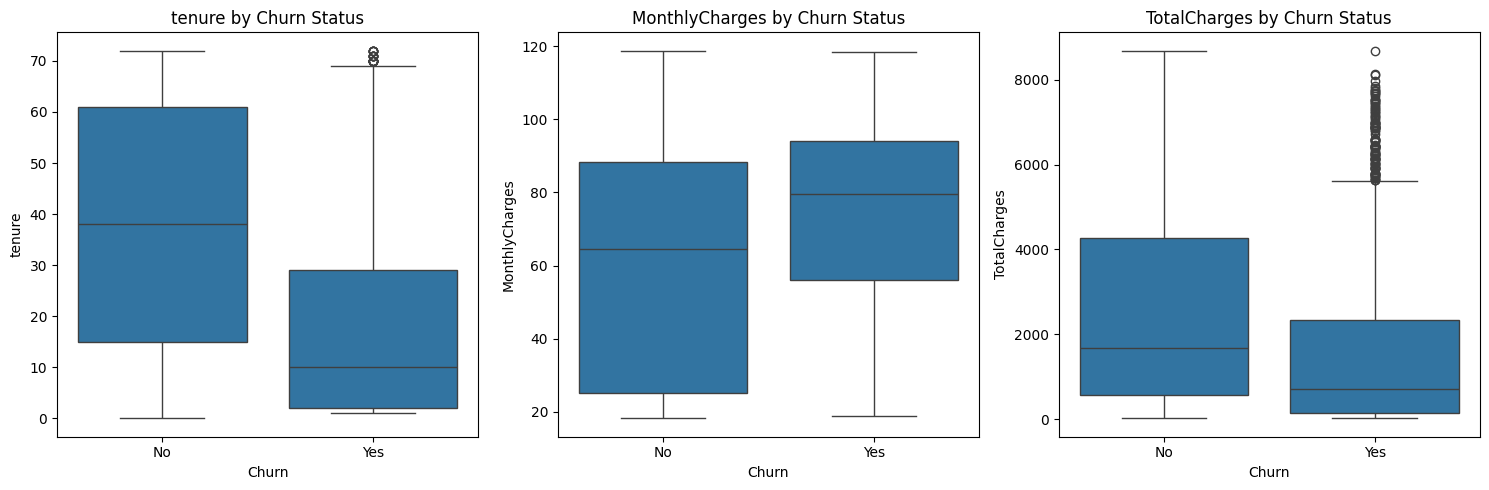

In [99]:
# Visualize distribution of numeric features by churn status
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Churn', y=feature, data=data)
    plt.title(f'{feature} by Churn Status')
plt.tight_layout()
plt.show()

In [100]:
#data = data.drop('CustomerID', axis=1)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
X= data.drop(['Churn', 'customerID', 'InternetService'], axis=1)
y= data['Churn']
categorical_cols = [col for col in categorical_cols if col != 'customerID']
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('Churn') # remove target from features
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print("Categorical Columns:", list(categorical_cols))
print("Numerical Columns:", list(numeric_cols))

Categorical Columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [101]:
# Create preprocessing pipeline
# 1. For Numeric columns: standard scaling
# 2. For categorical columns: one-hot encoding

preprocessor = ColumnTransformer(
    transformers= [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

In [102]:
# Lets see the shape of our training data
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (5634, 18)
Testing set shape: (1409, 18)


In [ ]:
# # Check what columns are in the dataset
# print("Columns in the dataset:", data.columns.tolist())

# # Identify categorical and numerical columns correctly
# categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
# numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# # Make sure 'Churn' is not in the feature columns (if it exists)
# if 'Churn' in numeric_cols:
#     numeric_cols.remove('Churn')

# print("Categorical columns:", categorical_cols)
# print("Numeric columns:", numeric_cols)

# # Now create X and y
# X = data.drop('Churn', axis=1)
# y = data['Churn']

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Create the preprocessor with handle_unknown
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_cols),
#         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
#     ])

# # Apply preprocessing
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [103]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply LAZYPREDICT
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

print("Model Comparison:")
print(models)


ValueError: A given column is not a column of the dataframe

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

# create and train a Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_processed, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_processed)
y_pred_proba = log_reg.predict_proba(X_test_processed)[:,1]

# Evaluate the model
print("classification_report:")
print(classification_report(y_test, y_pred))


classification_report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



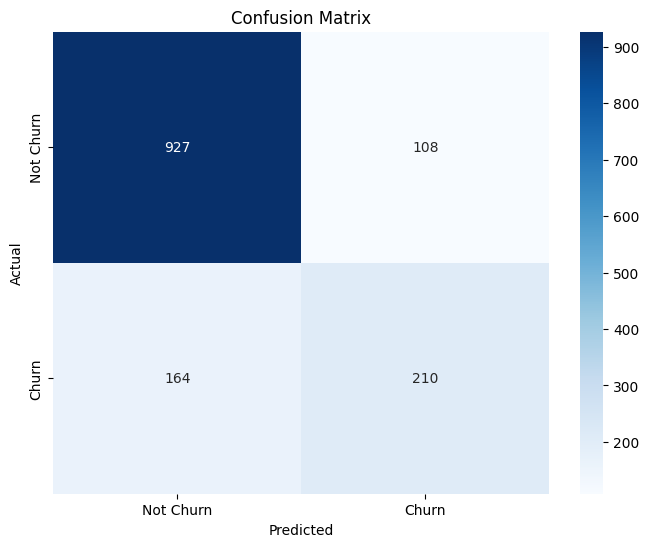

In [105]:
# Visualization
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churn', 'Churn'], 
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

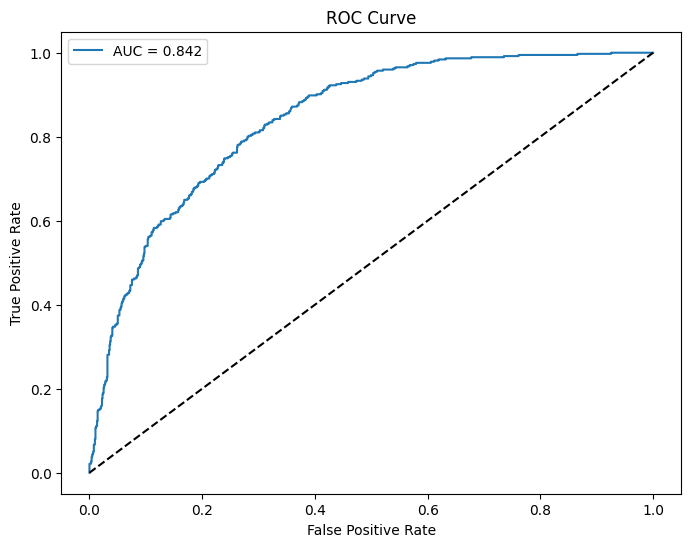

In [106]:
# Visulaization
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [107]:
# Hyper parameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid={
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2', None],
        'class_weight': [None, 'balanced']
    },
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_processed, y_train)
print("Best paramters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best paramters: {'C': 0.001, 'class_weight': None, 'penalty': None}
Best accuracy: 0.8051095270141418


/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_rati

In [108]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)
y_pred_best = best_model.predict(X_test_processed)
print("\nImproved Model Performance:")
print(classification_report(y_test,y_pred_best))


Improved Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [110]:
# Get feature importances from logistic regression coefficients
if hasattr(best_model, 'coef_'):
    # Get feature names from the preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # Get coefficients and their absolute values
    coefficients = best_model.coef_[0]
    importance = np.abs(coefficients)
    
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute Importance': importance
    })
    
    # Sort by absolute importance
    importance_df = importance_df.sort_values('Absolute Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:15], importance_df['Coefficient'][:15])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [111]:
# 1. Check correlation between features
correlation = X_train[['MonthlyCharges']].copy()
correlation['InternetService_Fiber'] = X_train['InternetService'] == 'Fiber optic'
correlation['Churn'] = y_train
print("Correlation Matrix:")
print(correlation.corr())

# 2. Plot distribution of MonthlyCharges by InternetService and Churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=pd.concat([X_train, y_train], axis=1))
plt.title('MonthlyCharges by InternetService and Churn Status')
plt.show()

# 3. Try a simpler model with fewer features to reduce multicollinearity
# Let's select a subset of important features
important_features = ['tenure', 'MonthlyCharges', 'InternetService', 'Contract', 'TechSupport', 'OnlineSecurity']
X_train_simple = X_train[important_features]
X_test_simple = X_test[important_features]

# Create a simpler preprocessor
simple_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['tenure', 'MonthlyCharges']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), 
         ['InternetService', 'Contract', 'TechSupport', 'OnlineSecurity'])
    ])

# Process the data
X_train_simple_processed = simple_preprocessor.fit_transform(X_train_simple)
X_test_simple_processed = simple_preprocessor.transform(X_test_simple)

# Train a logistic regression model
simple_model = LogisticRegression(random_state=42, max_iter=1000)
simple_model.fit(X_train_simple_processed, y_train)

# Get feature names
simple_feature_names = simple_preprocessor.get_feature_names_out()

# Show coefficients
coefficients = simple_model.coef_[0]
coef_df = pd.DataFrame({
    'Feature': simple_feature_names,
    'Coefficient': coefficients
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

print("\nFeature Coefficients (Simplified Model):")
print(coef_df)

# Plot coefficients
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Simplified Model')
plt.axvline(x=0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()

KeyError: 'InternetService'

In [112]:
# Import SHAP
import shap

# Calculate SHAP values for our logistic regression model
# First, let's create a proper explainer
explainer = shap.LinearExplainer(best_model, X_train_processed)

# Calculate SHAP values for a subset of test data
shap_values = explainer.shap_values(X_test_processed)

# Summary plot (should work fine)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed, 
                  feature_names=preprocessor.get_feature_names_out())
plt.title("SHAP Feature Importance Summary")
plt.tight_layout()
plt.show()

# Instead of force plot, let's try a decision plot which is often more reliable
plt.figure(figsize=(12, 8))
shap.decision_plot(explainer.expected_value, shap_values[:10], 
                  feature_names=preprocessor.get_feature_names_out())
plt.title("SHAP Decision Plot for 10 Samples")
plt.tight_layout()
plt.show()

# For individual explanations, let's use bar plots which are more reliable
sample_idx = 0  # First test sample
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values[sample_idx], feature_names=preprocessor.get_feature_names_out())
plt.title(f"Feature Contributions for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# Let's also try the waterfall plot for a single prediction
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx], 
                                     base_values=explainer.expected_value,
                                     data=X_test_processed[sample_idx],
                                     feature_names=preprocessor.get_feature_names_out()))
plt.title(f"SHAP Waterfall Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()



AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

<Figure size 1200x800 with 0 Axes>